In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

'''
1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.
'''

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, #지도학습용으로 데이터에 레이블 값 포함되어있음
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features['label'].num_classes # 함수 선언하는데 name error 발생해서 상단에 정의함
image_size = (64,64,3) # 훈련이 느려서 변경
batch_size = 16

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, image_size[:2])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)1
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    image_size_x = image_size[1]
    image_size_y = image_size[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=batch_size,
           img_size=image_size[0], num_classes=num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=batch_size,
          img_size=image_size[0], num_classes=num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=batch_size,
                               with_aug=False, with_cutmix=False, with_mixup=False,is_sparse=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=4) # lms 코어수 4개

    if not is_test and with_aug:
        ds = ds.map(augment,num_parallel_calls=4)

    ds = ds.batch(batch_size)

    if not is_sparse:
        ds = ds.map(onehot,num_parallel_calls=4) # onehot을 하면 에러나서 sparse인 부분에선 제외

    if not is_test and with_cutmix:
        ds = ds.map(cutmix,num_parallel_calls=4)

    if not is_test and with_mixup:
        ds = ds.map(mixup,num_parallel_calls=4)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

#No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용

ds_train_no_aug = apply_normalize_on_dataset(ds_train,is_sparse=True)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True,is_sparse=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test_non_sparse = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test_sparse = apply_normalize_on_dataset(ds_test, is_test=True,is_sparse=True)



In [16]:
'''
2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.
'''

resnet50_sparse = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(*image_size,), #image_size 변수로 넘기면 None,None,3으로 넘어감;
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_non_sparse = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(*image_size,),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])



In [20]:
'''
3. 모델 훈련하기

모델을 훈련시켜 주세요.
'''

EPOCH = 20

clone_model = keras.models.clone_model(resnet50_sparse)

resnet50_sparse.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

history_resnet50_no_aug = resnet50_sparse.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_sparse,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('resnet50_no_aug.h5')]
)

clone_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = clone_model.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_sparse,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('resnet50_aug.h5')]
)

clone_model_non_sparse = keras.models.clone_model(resnet50_non_sparse)

resnet50_non_sparse.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = resnet50_non_sparse.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_non_sparse,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('resnet50_aug_cutmix.h5')]
)


clone_model_non_sparse.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = clone_model_non_sparse.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_non_sparse,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('resnet50_aug_mixup.h5')]
)




Epoch 1/20
750/750 [==============================] - 54s 64ms/step - loss: 4.1618 - accuracy: 0.1011 - val_loss: 5.0180 - val_accuracy: 0.0323
Epoch 2/20
750/750 [==============================] - 47s 62ms/step - loss: 2.7315 - accuracy: 0.3353 - val_loss: 3.5621 - val_accuracy: 0.1915
Epoch 3/20
750/750 [==============================] - 46s 62ms/step - loss: 1.4092 - accuracy: 0.6532 - val_loss: 3.8052 - val_accuracy: 0.2022
Epoch 4/20
750/750 [==============================] - 47s 62ms/step - loss: 0.4344 - accuracy: 0.9194 - val_loss: 3.7436 - val_accuracy: 0.2257
Epoch 5/20
750/750 [==============================] - 45s 60ms/step - loss: 0.0966 - accuracy: 0.9893 - val_loss: 3.7648 - val_accuracy: 0.2380
Epoch 6/20
750/750 [==============================] - 42s 56ms/step - loss: 0.0430 - accuracy: 0.9957 - val_loss: 3.8338 - val_accuracy: 0.2352
Epoch 7/20
750/750 [==============================] - 42s 56ms/step - loss: 0.0661 - accuracy: 0.9928 - val_loss: 3.9530 - val_accuracy:

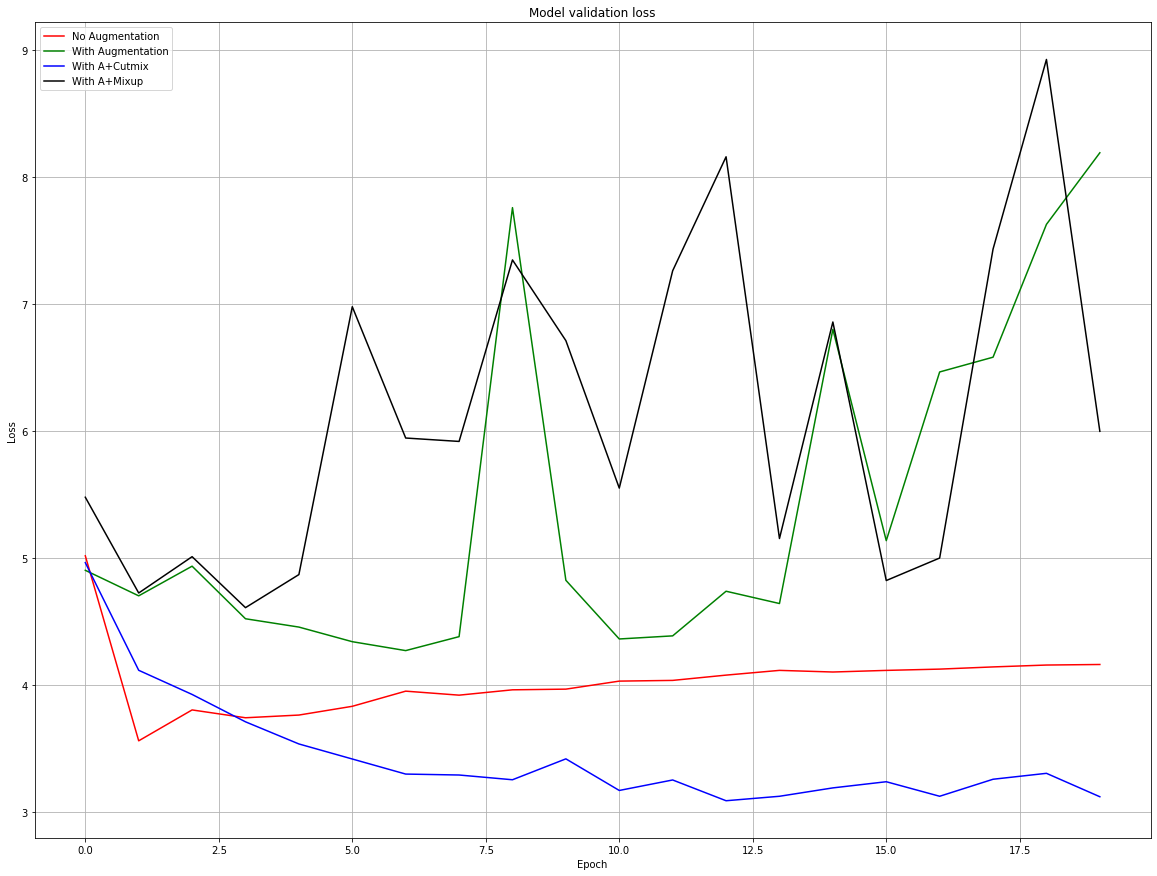

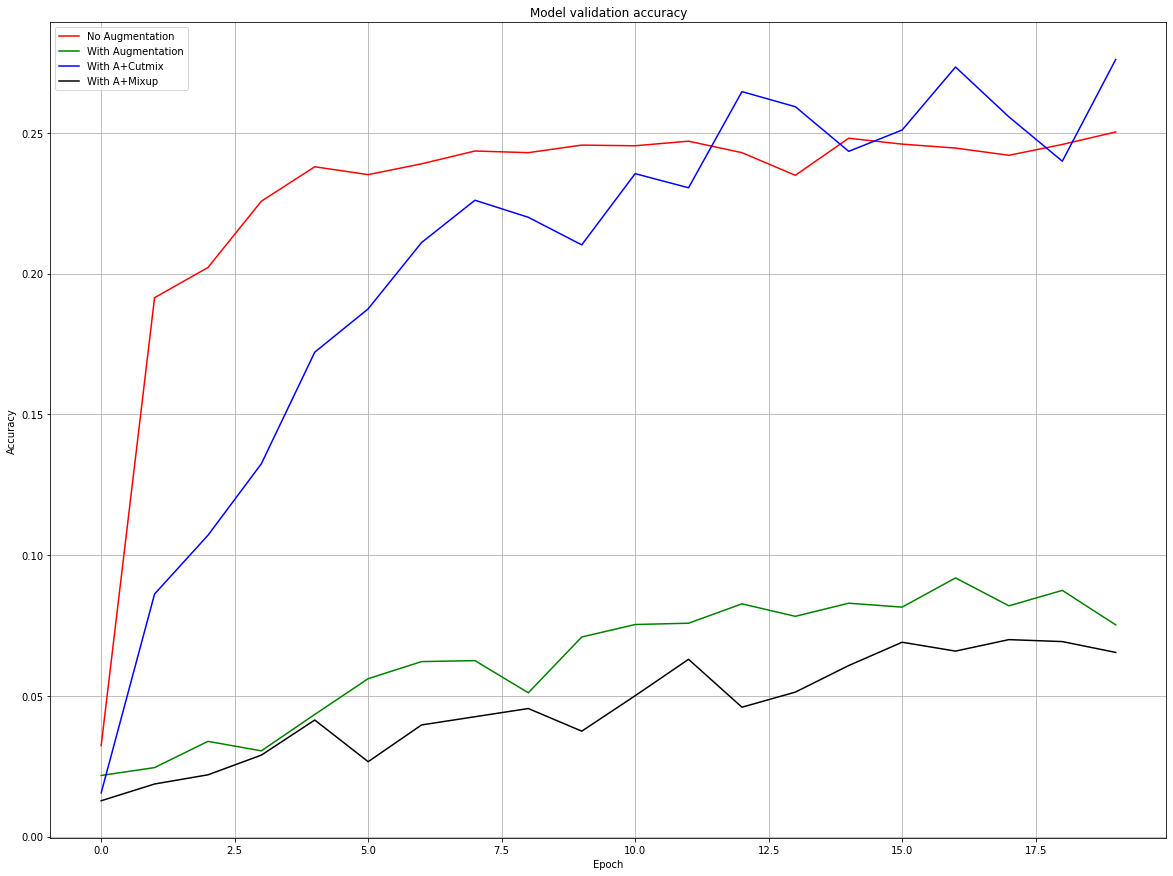

In [27]:
'''
4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화해 주세요.

'''
plt.figure(figsize=(20,15))

plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With A+Cutmix','With A+Mixup'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(20,15))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With A+Cutmix','With A+Mixup'], loc='upper left')
plt.grid(True)
plt.show()



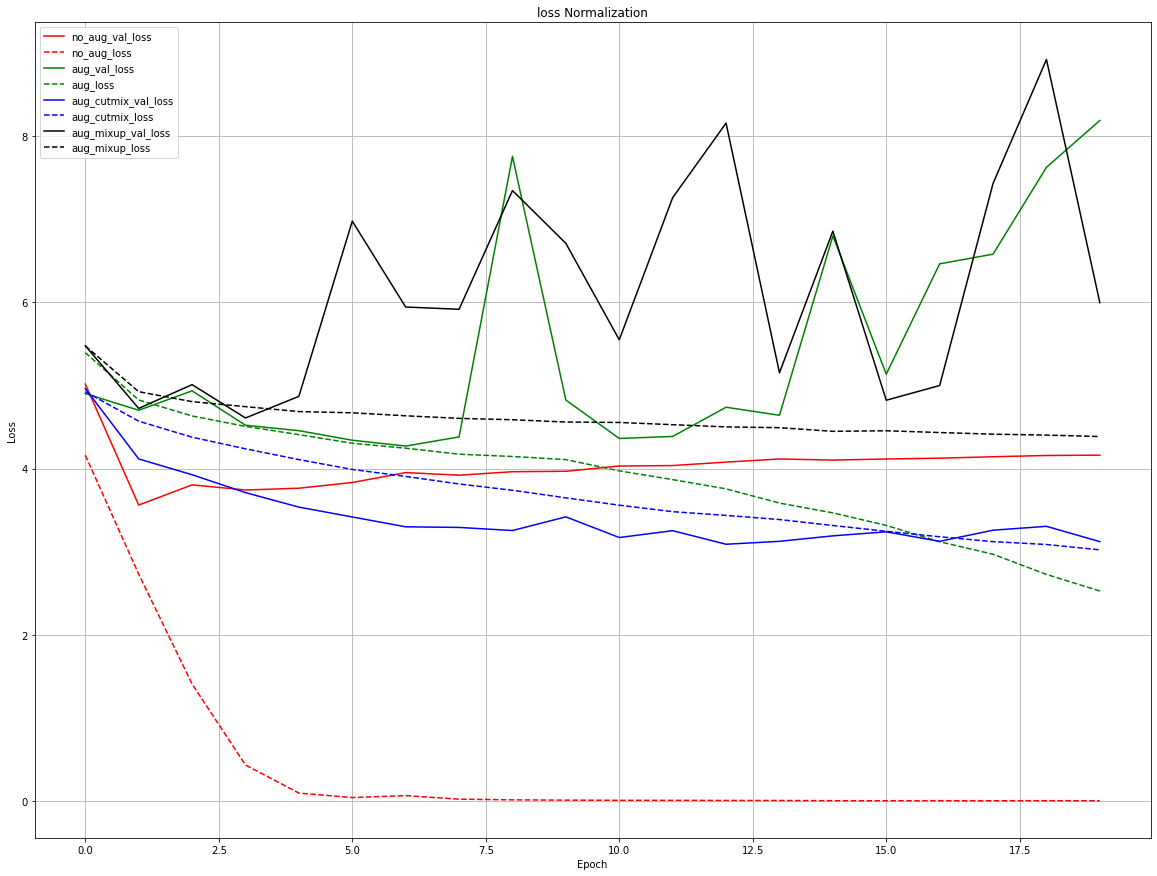

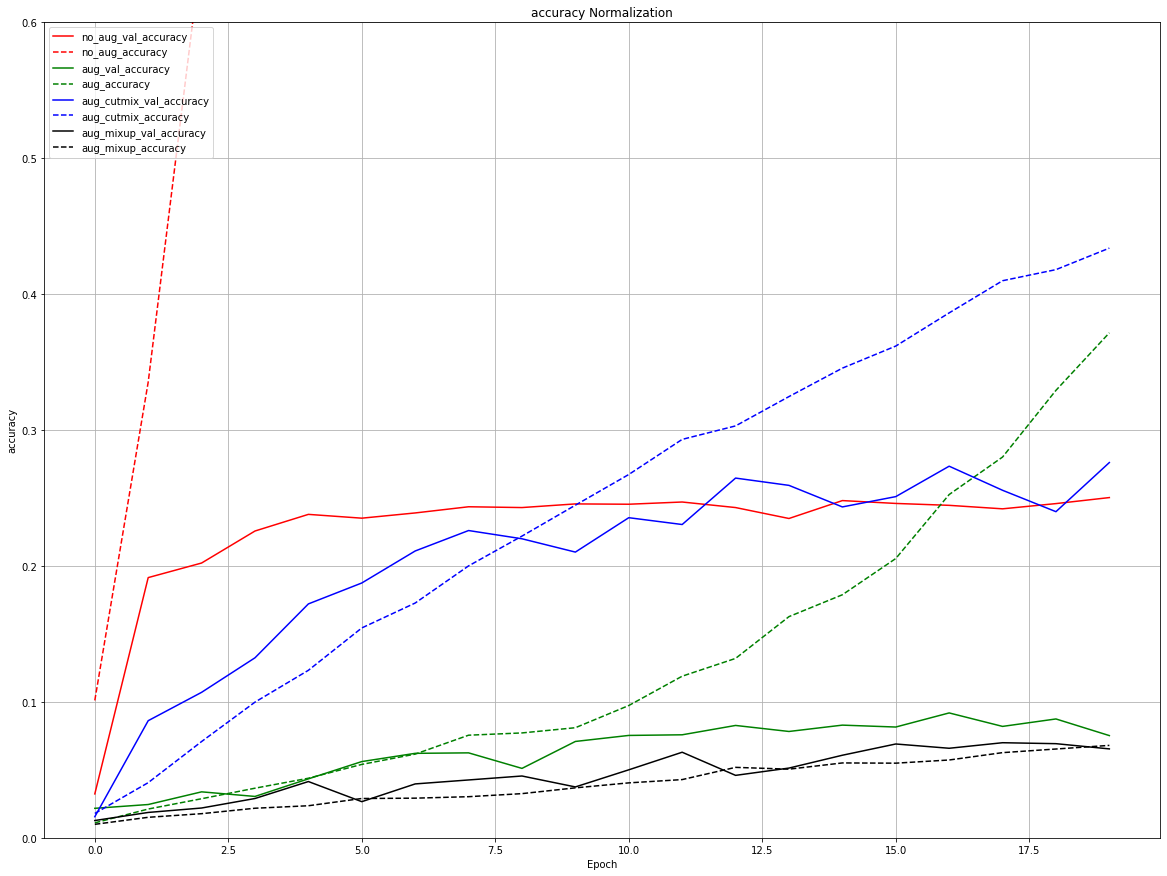

In [29]:
'''
5. Augmentation에 의한 모델 성능 비교

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용
 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고,
 Augmentation 방법들의 영향도에 대해 분석해 보세요.

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

'''

plt.figure(figsize=(20,15))

plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_no_aug.history['loss'], 'r--')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_aug.history['loss'], 'g--')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'k')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'k--')

plt.title('loss Normalization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug_val_loss','no_aug_loss',
            'aug_val_loss','aug_loss',
            'aug_cutmix_val_loss','aug_cutmix_loss',
            'aug_mixup_val_loss','aug_mixup_loss'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(20,15))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r--')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug.history['accuracy'], 'g--')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'k--')

plt.title('accuracy Normalization')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug_val_accuracy','no_aug_accuracy',
            'aug_val_accuracy','aug_accuracy',
            'aug_cutmix_val_accuracy','aug_cutmix_accuracy',
            'aug_mixup_val_accuracy','aug_mixup_accuracy'], loc='upper left')
plt.grid(True)
plt.ylim(0.0, 0.60)
plt.show()


# 속도를 위해 이미지 사이즈 및 에폭 수를 줄인 것으로 성능의 효과를 볼 수 없었으나,
# 일반화 성능에 대해서는 탁월한 성과를 보여주는 것으로 확인됨